### Imports and setup
* Imports text ML and evaluation tools
* Downloads linguistic resources(stopword, lemmatizer)

In [2]:
import pandas as pd 
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

pd.set_option("display.max_colwidth", 300)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himu7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\himu7\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Combined Dataset

In [3]:
df = pd.read_csv("../data/combined_news.csv")
print("Data Shape:", df.shape)
df.head(2)

Data Shape: (44898, 10)


,title,text,subject,date,label,text_length,title_length,date_parsed,year_month,content
0,"BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony","Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s fake news, or a hoax. However, the facts bear things out differently, and ...",News,"July 21, 2017",0,2114,76,2017-07-21,2017-07,"BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s ..."
1,Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO),"Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat him in the race to the White House. After all, how can we forget all the missteps, gaffes, weirdness, and sheer idiocies of such candidates as Jeb Bush, Marco Rubio, J...",News,"May 7, 2016",0,2823,71,2016-05-07,2016-05,"Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO) Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat him in the race to the White House. After all, how can we forget all the missteps, gaffes, weir..."


### Basic Sanity Check

In [4]:
df["label"].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

### Train-Test Split

In [5]:
X = df["content"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)

Train size:  (35918,)
Test size:  (8980,)


### Define Preprocessing Functions

* `clean_basic()` is to normalize the text by converting everything to lowercase and removing URLs and HTML tage, which are noise for NLP models.

* `clean_no_punct()` is to remove punctuation so symbols like commas or exclamation marks don't get treated as features.

* `clean_no_stopwords()` is to split text into words, remove stopwords like the, is And andm and then join the remaining meaningful words back into a sentence.

*  `clean_lemmatized()` is to lemmatize each word, converting words like running to run and cars to car, which reduces vocabulary size and imporoves generalization.

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_basic(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    return text

def clean_no_punct(text):
    text = clean_basic(text)
    return text.translate(str.maketrans("", "", string.punctuation))

def clean_no_stopwords(text):
    text = clean_no_punct(text)
    tokens = text.split()
    return " ".join([t for t in tokens if t not in stop_words])

def clean_lemmatized(text):
    text = clean_no_stopwords(text)
    tokens = text.split()
    return " ".join([lemmatizer.lemmatize(t) for t in tokens])

### Apply Preprocessing Variants

Applying text cleaning functions to the training and testing dataset to create multiple cleaned version on the same text.

In [7]:
X_train_basis = X_train.apply(clean_basic)
X_test_basis = X_test.apply(clean_basic)

X_train_nonpunct = X_train.apply(clean_no_punct)
X_test_nopunct = X_test.apply(clean_no_punct)

X_train_nostop = X_train.apply(clean_no_stopwords)
X_test_nostop = X_test.apply(clean_no_stopwords)

X_train_lemma = X_train.apply(clean_lemmatized)
X_test_lemma = X_test.apply(clean_lemmatized)

### Tf-Idf Vectorizzer

Configured a TF-IDF vectorizer to convert text into numerical features while controlling noise and context.

In [8]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df = 5, 
    max_df = 0.95, 
    sublinear_tf=True
)

### Define Models to Compare

Created a dictionary of different machine-learning models so we can train and compare them easily using the same data.

* `Naive Bayes` because it is fast, simple, and works well with TF-IDF features for text classification.
* `Logistic Regression` because it has higher iteration limit to ensure proper convergence on higher-dimensional text data.
* `SVM` because it is strong for text classificationi and often performs well with sparse, high-dimensional features.

In [9]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

### Evaluation Function

Writing this function to train, evaluate and compare multiple models using a specific preprocessing strategy. 

First print the preprocessing label so we know which text-cleaning version is being evaluated

In [10]:
def evaluate_models(Xtr, Xte, ytr, yte, label):
    print(f"\n------ Preprocessing: {label} ------")

    Xtr_vec = vectorizer.fit_transform(Xtr)
    Xte_vec = vectorizer.transform(Xte)

    scores = {}

    for name, model in models.items():
        model.fit(Xtr_vec, ytr)
        preds = model.predict(Xte_vec)
        f1 = f1_score(yte, preds)
        scores[name] = f1
        print(f"{name} : F1-score: {f1:.4f}")

    return scores

### Run Experiments 

Create a reults dictionary to store model performance for different text-preprocessing strategies. For each preprocessing method(basic cleaning, no punctuatoin, no stopwords and lemmatization), this is called `evaluate_models` function using the corresponding cleaned training and test datasets.

In [11]:
results = {}

results["Basic"] = evaluate_models(
    X_train_basis, X_test_basis, y_train, y_test, "Basic Cleaning"
)

results["No Punctuation"] = evaluate_models(
    X_train_nonpunct, X_test_nopunct, y_train, y_test, "No Punctuation"
)

results["No Stopwords"] = evaluate_models(
    X_train_nostop, X_test_nostop, y_train, y_test, "No Stopwords"
)

results["Lemmatizer"] = evaluate_models(
    X_train_lemma, X_test_lemma, y_train, y_test, "Lemmatized"
)


------ Preprocessing: Basic Cleaning ------
Naive Bayes : F1-score: 0.9575
Logistic Regression : F1-score: 0.9903
Linear SVM : F1-score: 0.9967

------ Preprocessing: No Punctuation ------
Naive Bayes : F1-score: 0.9580
Logistic Regression : F1-score: 0.9909
Linear SVM : F1-score: 0.9961

------ Preprocessing: No Stopwords ------
Naive Bayes : F1-score: 0.9653
Logistic Regression : F1-score: 0.9920
Linear SVM : F1-score: 0.9979

------ Preprocessing: Lemmatized ------
Naive Bayes : F1-score: 0.9660
Logistic Regression : F1-score: 0.9919
Linear SVM : F1-score: 0.9977


### Visualtization :
* Bar chart per processing method
* Overall comparison heatmap (best for analysis)

In [12]:
result_df = pd.DataFrame(results).T
result_df

,Naive Bayes,Logistic Regression,Linear SVM
Basic,0.957457,0.990327,0.996732
No Punctuation,0.958022,0.990905,0.996150
No Stopwords,0.965349,0.991974,0.997902
Lemmatizer,0.966039,0.991857,0.997668


### Visualization code to compare mmodels across preprocessing methods using `results` dictionary 

* Bar cahrt per preprocessing method 
* Overall comperison heatmap (best analysis)

#### Bar Chart: Model performance per perprocessing

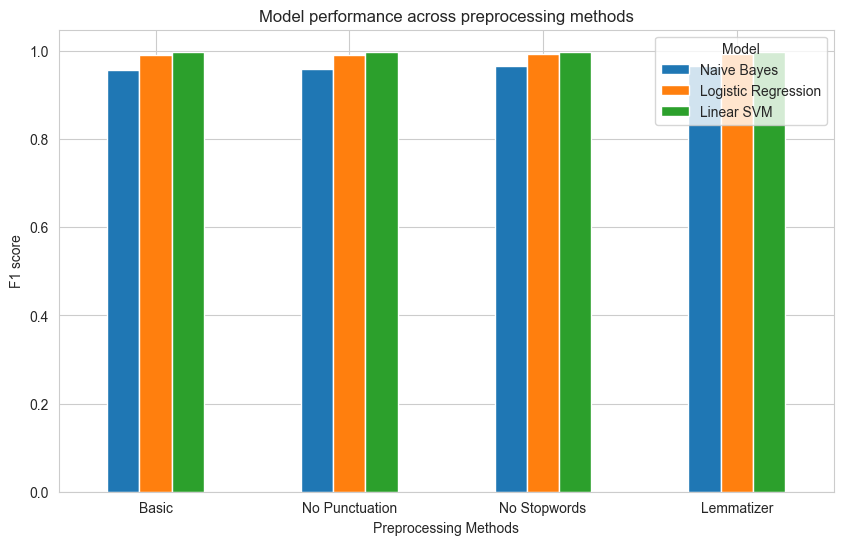

In [13]:
result_df.plot(
    kind = "bar",
    figsize=(10,6)
)

plt.title("Model performance across preprocessing methods")
plt.ylabel("F1 score")
plt.xlabel("Preprocessing Methods")
plt.xticks(rotation=0)
plt.legend(title = "Model")
plt.show()

#### Heatmap: Best overall comparison

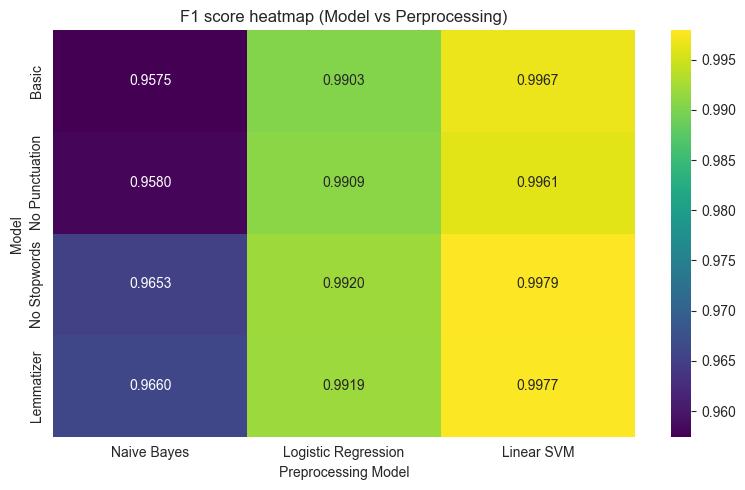

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(
    result_df,
    annot=True, 
    fmt=".4f",
    cmap = "viridis"
)

plt.title("F1 score heatmap (Model vs Perprocessing)")
plt.xlabel("Preprocessing Model")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

#### Line Plot(trend-fouced)

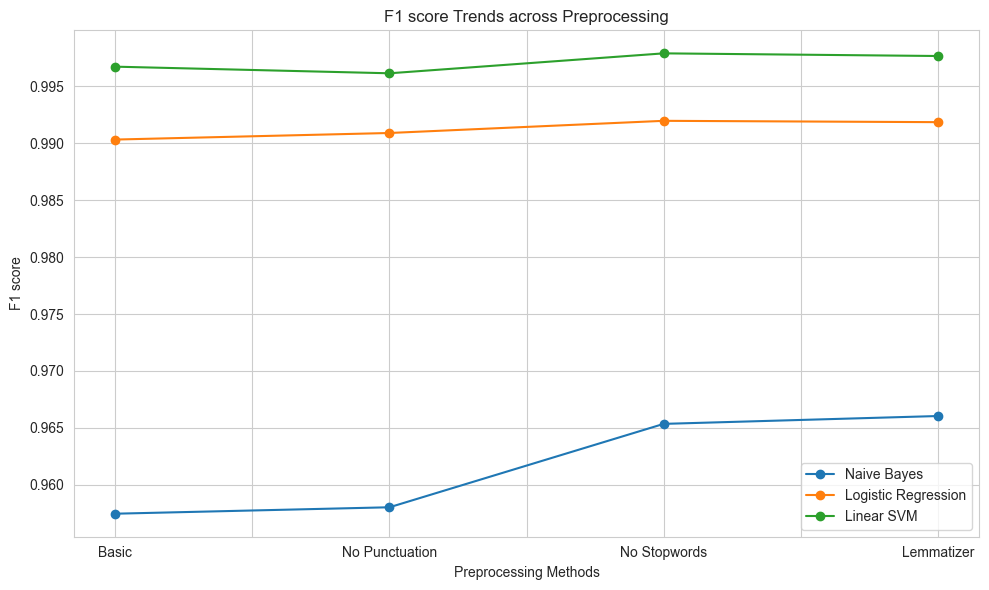

In [15]:
result_df.plot(
    marker="o",
    figsize=(10,6)
)

plt.title("F1 score Trends across Preprocessing")
plt.ylabel("F1 score")
plt.xlabel("Preprocessing Methods")
plt.xticks(rotation = 0)
plt.grid(True)
plt.tight_layout()
plt.show()

### Best Combination Identification 

Serach through all the f1 scores in result tabel to find best-performing combination of preprocessing method and machine-learning model.

Flattened the result DataFrame so every preprocessing-model pair could be compared, then identifed the one with hightest f1-score

In [16]:
best_combo = result_df.stack().idxmax()
best_score = result_df.stack().max()

print("Best Preprocessing + Model combination: ")
print("Preproccessing: ", best_combo[0])
print("Model: ", best_combo[1])
print("F1-score: ", best_score)

Best Preprocessing + Model combination: 
Preproccessing:  No Stopwords
Model:  Linear SVM
F1-score:  0.9979016087666123


### Inspect Sample Transformation 

* Selected one text sample from training data.
* Printed the original raw text to see what the model receives initially.
* Display all version side by side so we could compare how each preprocessing step transforms the same text

In [17]:
sample = X_train.iloc[0]

print("Original: \n", sample[:400],"\n")
print("Basic:\n", clean_basic(sample)[:400], "\n")
print("No Stopwords: \n", clean_no_stopwords(sample)[:400], "\n")
print("Lemmatizer:\n", clean_lemmatized(sample)[:400])

Original: 
 Syria investigator del Ponte signs off with a sting GENEVA (Reuters) - Veteran prosecutor Carla del Ponte signed off from the United Nations Syria investigation on Monday by criticizing the U.N. Security Council and telling Syria s ambassador his government had used chemical weapons. The former Swiss attorney general, who went on to prosecute war crimes in Rwanda and former Yugoslavia, said in Aug 

Basic:
 syria investigator del ponte signs off with a sting geneva (reuters) - veteran prosecutor carla del ponte signed off from the united nations syria investigation on monday by criticizing the u.n. security council and telling syria s ambassador his government had used chemical weapons. the former swiss attorney general, who went on to prosecute war crimes in rwanda and former yugoslavia, said in aug 

No Stopwords: 
 syria investigator del ponte signs sting geneva reuters veteran prosecutor carla del ponte signed united nations syria investigation monday criticizing un sec